# Парсер файла с петлями

## 1. Получение и запись в файл геномной последовательности петель

In [2]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [3]:
loops_info = pd.read_excel('../data/dicty_loop_positions_Chr1_Chr6.xlsx')
window_size = 2000
excel_resolution = 2000

In [3]:
loops_info.head()

,Chr,ID,"Genomic bin, Left base","Genomic bin, Right base",Size (Kb),"""Extrusion track""","Note for extrusion tracks: 0=n/a, 1=from the left base, 2=from the right base"
0,1,1,107,114,16,0,NaN
1,1,2,114,123,20,1,NaN
2,1,3,176,187,24,2,NaN
3,1,4,187,194,16,0,NaN
4,1,5,194,209,32,2,NaN


In [4]:
chr_with_loops = sorted(loops_info.Chr.unique())

### 1.1. Готовим позиции с окошками (без повторов)

In [157]:
koef = window_size * 1.0 / excel_resolution 
loops_positions = {}
for chr_name in chr_with_loops:
    chr_loop_positions = {}
    chr_positions = loops_info[loops_info['Chr'] == chr_name]['Genomic bin, Left base']
    chr_positions = chr_positions.append(loops_info[loops_info['Chr'] == chr_name]['Genomic bin, Right base'], \
                                         ignore_index=True)
    chr_positions = sorted(chr_positions.drop_duplicates())
    
    # убираем наложение промежутков
    for pos in chr_positions:
        if pos in chr_loop_positions.values():
            chr_loop_positions[pos] = pos + koef
        else:
            chr_loop_positions[pos - koef] = pos + koef
            
    loops_positions[chr_name] = chr_loop_positions

In [124]:
# Односторонние окошки
loops_positions = {}
for chr_name in chr_with_loops:
    chr_loop_positions = {}
    chr_positions = loops_info[loops_info['Chr'] == chr_name]['Genomic bin, Left base']
    chr_positions = chr_positions.drop_duplicates()
    # левые позиции
    for pos in chr_positions:
        if pos in chr_loop_positions.values():
            continue
        chr_loop_positions[pos - 1] = pos
        
    # правые позиции 
    chr_positions = loops_info[loops_info['Chr'] == chr_name]['Genomic bin, Right base']
    chr_positions = chr_positions.drop_duplicates()
    for pos in chr_positions:
        if pos in chr_loop_positions.keys():
            continue
        chr_loop_positions[pos] = pos + 1
    
    loops_positions[chr_name] = chr_loop_positions

### 1.2. Запись файлов с петлями и без петель

In [158]:
genome = SeqIO.parse(open('../data/dicty.fa'),'fasta')
loop_seq_records = []
without_loop_seq_records = []
for chr_name in chr_with_loops:
    for chrom in genome:
        chrom_name = chrom.name[3 : ]
        if chrom_name != str(chr_name):
            continue
        
        loop_seq = ''
        without_loop_seq = ''
        left_index = 0
        chr_loop_positions = loops_positions[chr_name]
        for (start, end) in sorted(chr_loop_positions.iteritems()):
            start_index = int (start * excel_resolution)
            end_index = int(end * excel_resolution)
            loop_seq = loop_seq + chrom.seq[start_index : end_index]
            without_loop_seq = without_loop_seq + chrom.seq[left_index : start_index]
            left_index = end_index
        loop_record = SeqRecord(loop_seq, 'chr' + chrom_name)
        loop_seq_records.append(loop_record)
        without_loop_record = SeqRecord(without_loop_seq, 'chr' + chrom_name)
        without_loop_seq_records.append(without_loop_record)
        break

SeqIO.write(loop_seq_records, "../data/loops_seq.fasta", "fasta")
SeqIO.write(without_loop_seq_records, "../data/without_loops_seq.fasta", "fasta")

2

In [207]:
dir = "../data/"
for seq in loop_seq_records:
    filename = dir + "loop_" + seq.id + ".txt"
    with open(filename, 'w') as out:
        out.write(str(seq.seq))
for seq in without_loop_seq_records:
    filename = dir + "without_loops_" + seq.id + ".txt"
    with open(filename, 'w') as out:
        out.write(str(seq.seq))

## 2. Подсчет среднего и дисперсии нуклеотидного и динуклеотидного состава

In [159]:
!sh ./script.sh ../data/loops_seq.fasta ../data/loops.tsv ../data/loops2.tsv
!sh ./script.sh ../data/without_loops_seq.fasta ../data/dicty.tsv ../data/dicty2.tsv

In [255]:
dicty_chars2 = pd.read_csv('../data/background/tsv/loops/outer_loops2.tsv', sep='\t') #('../data/dicty2.tsv', sep='\t')
loops_chars2 = pd.read_csv('../data/background/tsv/loops/left_loops2.tsv', sep='\t') #('../data/loops2.tsv', sep='\t')

In [256]:
inner_chars2 = pd.read_csv('../data/background/tsv/loops/inner_loops2.tsv', sep='\t')
left_right_loops_chars2 = pd.read_csv('../data/background/tsv/loops/left_right_loops2.tsv', sep='\t')
right_loops_chars2 = pd.read_csv('../data/background/tsv/loops/right_loops2.tsv', sep='\t')

In [160]:
inner_chars2 = dicty_chars2.append(pd.read_csv('../data/background/tsv/loops/inner_loops2.tsv', sep='\t'), ignore_index=True)
right_loops_chars2 = loops_chars2.append(pd.read_csv('../data/background/tsv/loops/right_loops2.tsv', sep='\t'), ignore_index=True)

In [258]:
print dicty_chars2.shape
print loops_chars2.shape
print inner_chars2.shape
print left_right_loops_chars2.shape
print right_loops_chars2.shape

(521565, 4)
(65189, 4)
(556489, 4)
(96508, 4)
(65183, 4)


In [209]:
dicty_chars2.head()

,nucleotides,frequency,bins,Unnamed: 3
0,ACC,0.01,0_2000,NaN
1,AGG,0.01,0_2000,NaN
2,CCT,0.01,0_2000,NaN
3,AGC,0.01,0_2000,NaN
4,AGA,0.02,0_2000,NaN


In [210]:
loops_chars2.head()

,nucleotides,frequency,bins,Unnamed: 3
0,ACC,0.01,0_2000,NaN
1,AGG,0.01,0_2000,NaN
2,CCT,0.00,0_2000,NaN
3,AGC,0.00,0_2000,NaN
4,AGA,0.01,0_2000,NaN


In [336]:
nucs = ['A', 'C', 'T', 'G', 'G/C', 'A/T', 'A/T/G', 'T/G/C']
dinucs = ['AA', 'AC', 'AT', 'AG', 'CA', 'CC', 'CT', 'CG', 'TA', 'TC', 'TT', 'TG', 'GA', 'GC', 'GT', 'GG']
trinucs = []
for i in xrange(0, 4):
    for j in xrange(0, 4):
        for k in xrange(0, 4):
            trinucs.append(nucs[i] + nucs[j] + nucs[k])
half_len = len(trinucs)//4
trinucs2 = trinucs[half_len : 2*half_len]
trinucs3 = trinucs[2*half_len : 3*half_len]
trinucs4 = trinucs[3*half_len : ]
trinucs = trinucs[0 : half_len]

In [315]:
nuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(nucs)]
nuc_df2['type'] = 'loop' #'left_loop' #'loop'
dinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(dinucs)]
dinuc_df2['type'] = 'loop' #'left_loop' #'loop'
trinuc_df = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs)]
trinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs2)]
trinuc_df3 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs3)]
trinuc_df4 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs4)]
trinuc_df['type'] = 'loop' #'left_loop' #'loop'
trinuc_df2['type'] = 'loop' #'left_loop' #'loop'
trinuc_df3['type'] = 'loop' #'left_loop' #'loop'
trinuc_df4['type'] = 'loop' #'left_loop' #'loop'
nuc_df2.count()

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

nucleotides    5920
frequency      5920
bins           5920
Unnamed: 3        0
type           5920
dtype: int64

In [316]:
right_nuc_df2 = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(nucs)]
right_nuc_df2['type'] = 'loop'#'right_loop' #'loop'
right_dinuc_df2 = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(dinucs)]
right_dinuc_df2['type'] = 'loop'#'right_loop' #'loop'
right_trinuc_df = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(trinucs)]
right_trinuc_df2 = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(trinucs2)]
right_trinuc_df3 = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(trinucs3)]
right_trinuc_df4 = right_loops_chars2.loc[right_loops_chars2['nucleotides'].isin(trinucs4)]
right_trinuc_df['type'] = 'loop'#'right_loop' #'loop'
right_trinuc_df2['type'] = 'loop'#'right_loop' #'loop'
right_trinuc_df3['type'] = 'loop'#'right_loop' #'loop'
right_trinuc_df4['type'] = 'loop'#'right_loop' #'loop'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [317]:
left_right_nuc_df2 = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(nucs)]
left_right_nuc_df2['type'] = 'loop' #'left_right_loop' #'loop'
left_right_dinuc_df2 = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(dinucs)]
left_right_dinuc_df2['type'] = 'loop' #'left_right_loop' #'loop'
left_right_trinuc_df = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(trinucs)]
left_right_trinuc_df2 = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(trinucs2)]
left_right_trinuc_df3 = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(trinucs3)]
left_right_trinuc_df4 = left_right_loops_chars2.loc[left_right_loops_chars2['nucleotides'].isin(trinucs4)]
left_right_trinuc_df['type'] = 'loop' #'left_right_loop' #'loop'
left_right_trinuc_df2['type'] = 'loop' #'left_right_loop' #'loop'
left_right_trinuc_df3['type'] = 'loop' #'left_right_loop' #'loop'
left_right_trinuc_df4['type'] = 'loop' #'left_right_loop' #'loop'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [318]:
temp_df = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(nucs)]
temp_df['type'] = 'dicty' #'outer'
temp_df2 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(dinucs)]
temp_df2['type'] = 'dicty' #'outer'
temp_df3 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs)]
temp_df4 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs2)]
temp_df5 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs3)]
temp_df6 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs4)]
temp_df3['type'] = 'dicty' #'outer'
temp_df4['type'] = 'dicty' #'outer'
temp_df5['type'] = 'dicty' #'outer'
temp_df6['type'] = 'dicty' #'outer'
temp_df.count()

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

nucleotides    47320
frequency      47320
bins           47320
Unnamed: 3         0
type           47320
dtype: int64

In [319]:
inner_temp_df = inner_chars2.loc[inner_chars2['nucleotides'].isin(nucs)]
inner_temp_df['type'] = 'dicty' #'inner'
inner_temp_df2 = inner_chars2.loc[inner_chars2['nucleotides'].isin(dinucs)]
inner_temp_df2['type'] = 'dicty' #'inner'
inner_temp_df3 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs)]
inner_temp_df4 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs2)]
inner_temp_df5 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs3)]
inner_temp_df6 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs4)]
inner_temp_df3['type'] = 'dicty' #'inner'
inner_temp_df4['type'] = 'dicty' #'inner'
inner_temp_df5['type'] = 'dicty' #'inner'
inner_temp_df6['type'] = 'dicty' #'inner'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [320]:
nuc_df2 = pd.concat([nuc_df2, right_nuc_df2, left_right_nuc_df2, temp_df, inner_temp_df])
dinuc_df2 = pd.concat([dinuc_df2, right_dinuc_df2, left_right_dinuc_df2, temp_df2, inner_temp_df2])
trinuc_df = pd.concat([trinuc_df, right_trinuc_df, left_right_trinuc_df, temp_df3, inner_temp_df3])
trinuc_df2 = pd.concat([trinuc_df2, right_trinuc_df2, left_right_trinuc_df2, temp_df4, inner_temp_df4])
trinuc_df3 = pd.concat([trinuc_df3, right_trinuc_df3, left_right_trinuc_df3, temp_df5, inner_temp_df5])
trinuc_df4 = pd.concat([trinuc_df4, right_trinuc_df4, left_right_trinuc_df4, temp_df6, inner_temp_df6])

In [321]:
nuc_df2.count()

nucleotides    118448
frequency      118448
bins           118448
Unnamed: 3          0
type           118448
dtype: int64

In [322]:
dinuc_df2.head()

,nucleotides,frequency,bins,Unnamed: 3,type
14,GT,0.03,0_2000,NaN,loop
15,GG,0.03,0_2000,NaN,loop
17,GC,0.01,0_2000,NaN,loop
19,GA,0.05,0_2000,NaN,loop
57,CC,0.02,0_2000,NaN,loop


## 3. Графики

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", rc = {'figure.figsize':(12.7,10.27)})

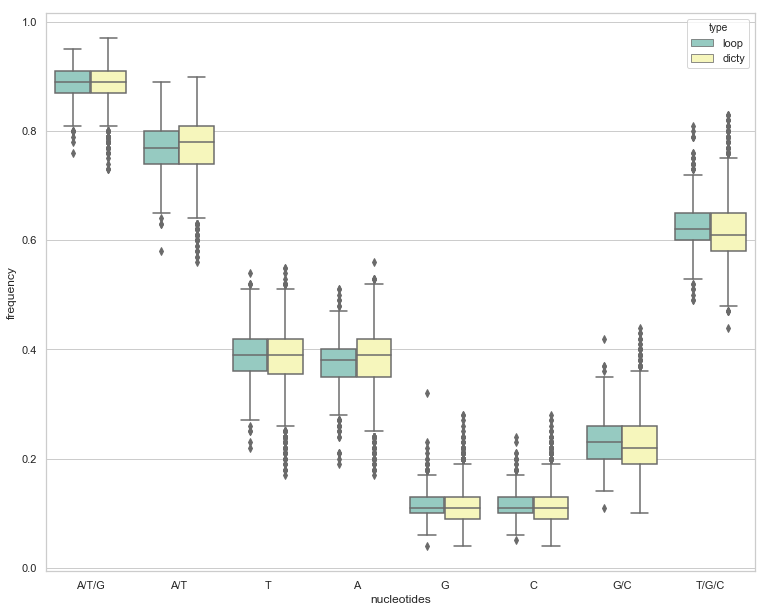

In [173]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=nuc_df2, palette="Set3")
plt.show()

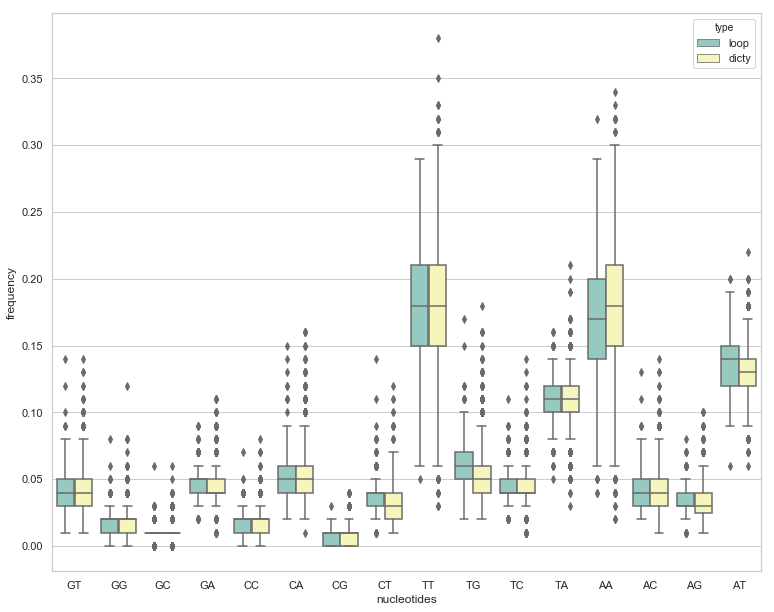

In [174]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=dinuc_df2, palette="Set3")
plt.show()

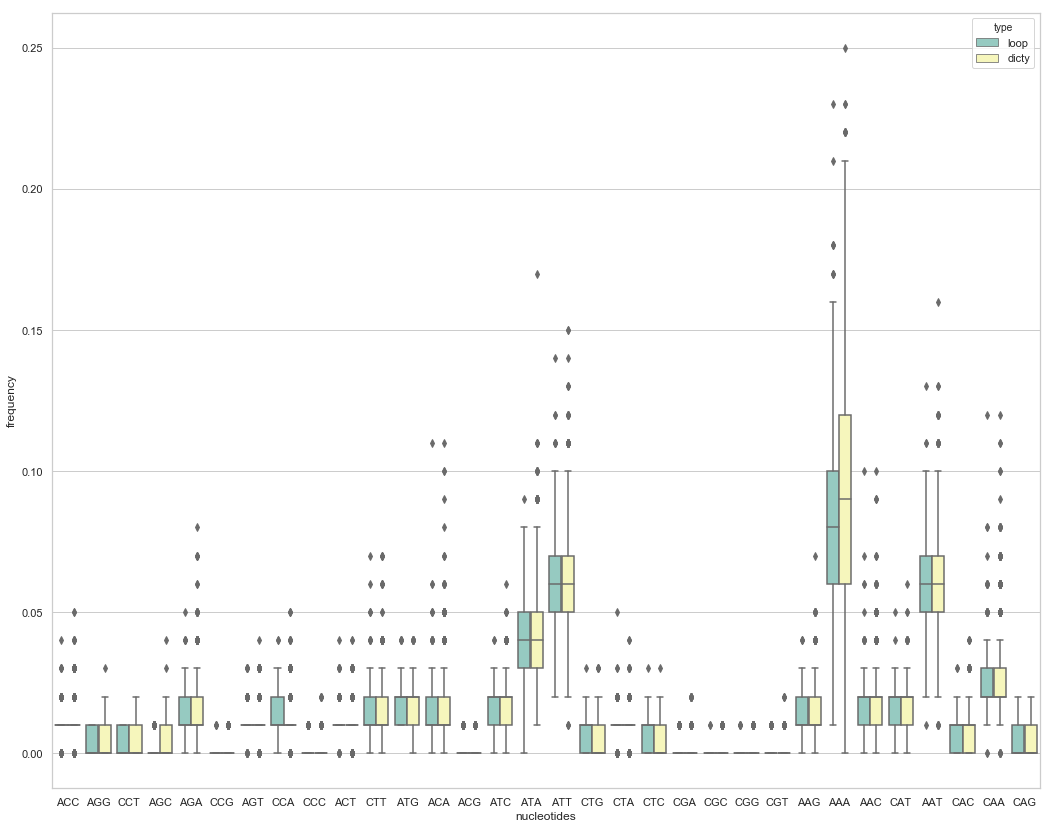

In [175]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df, palette="Set3")
plt.show()

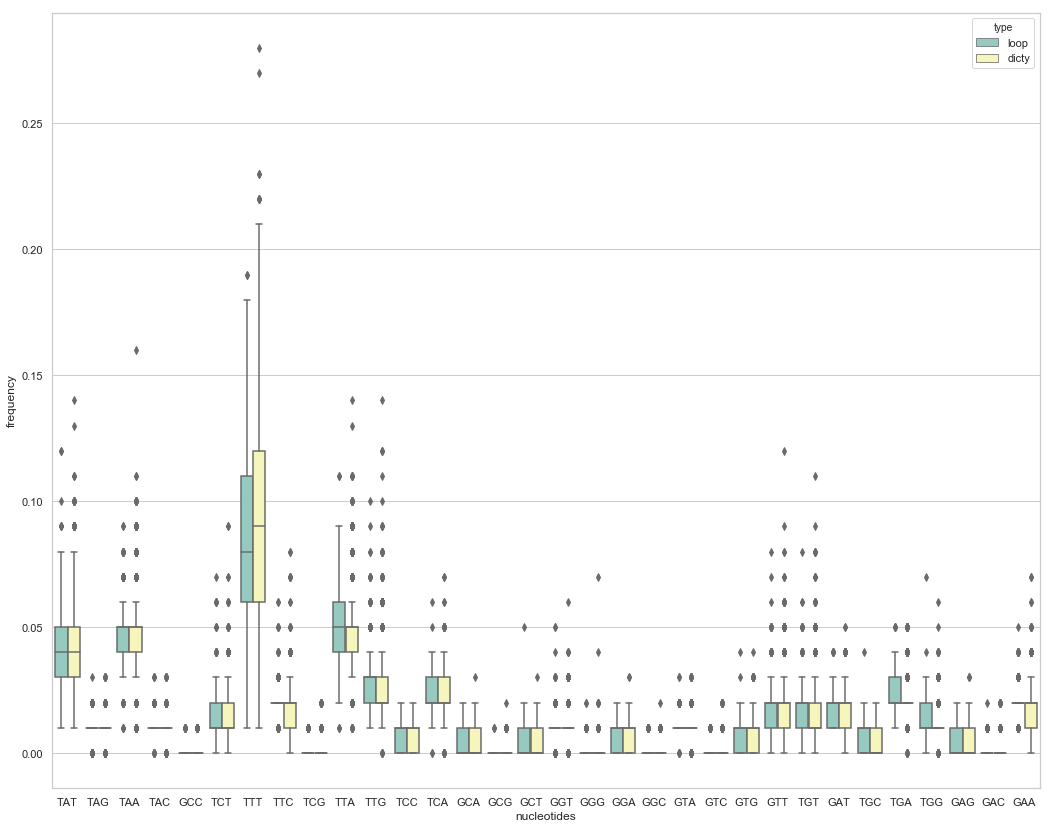

In [176]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df2, palette="Set3")
plt.show()

## Новые данные

In [398]:
dr = '../data/background/fasta/'

In [456]:
!sh ./script.sh ../data/background/fasta/loops_seq.fasta ../data/background/tsv/loops/loops.tsv ../data/background/tsv/loops/loops2.tsv
!sh ./script.sh ../data/background/fasta/loops_extr_seq.fasta ../data/background/tsv/loops/loops_extr.tsv ../data/background/tsv/loops/loops_extr2.tsv
!sh ./script.sh ../data/background/fasta/inner_seq.fasta ../data/background/tsv/loops/inner.tsv ../data/background/tsv/loops/inner2.tsv
!sh ./script.sh ../data/background/fasta/outer_seq.fasta ../data/background/tsv/loops/outer.tsv ../data/background/tsv/loops/outer2.tsv

In [4]:
dicty_chars2 = pd.read_csv('../data/background/tsv/loops/outer2.tsv', sep='\t')
loops_chars2 = pd.read_csv('../data/background/tsv/loops/loops2.tsv', sep='\t')
inner_chars2 = pd.read_csv('../data/background/tsv/loops/inner2.tsv', sep='\t')
loops_extr_chars2 = pd.read_csv('../data/background/tsv/loops/loops_extr2.tsv', sep='\t')

In [5]:
nucs = ['A', 'C', 'T', 'G', 'G/C', 'A/T', 'A/T/G', 'T/G/C']
dinucs = ['AA', 'AC', 'AT', 'AG', 'CA', 'CC', 'CT', 'CG', 'TA', 'TC', 'TT', 'TG', 'GA', 'GC', 'GT', 'GG']
trinucs = []
forth_mers = []
fifth_mers = []
for i in xrange(0, 4):
    for j in xrange(0, 4):
        for k in xrange(0, 4):
            trinucs.append(nucs[i] + nucs[j] + nucs[k])
            for l in xrange(0, 4):
                forth_mers.append(nucs[i] + nucs[j] + nucs[k] + nucs[l])
                for m in xrange(0, 4):
                    fifth_mers.append(nucs[i] + nucs[j] + nucs[k] + nucs[l])
half_len = len(trinucs)//4
trinucs2 = trinucs[half_len : 2*half_len]
trinucs3 = trinucs[2*half_len : 3*half_len]
trinucs4 = trinucs[3*half_len : ]
trinucs = trinucs[0 : half_len]

In [6]:
nuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(nucs)]
nuc_df2['type'] = 'loop' 
dinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(dinucs)]
dinuc_df2['type'] = 'loop'
trinuc_df = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs)]
trinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs2)]
trinuc_df3 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs3)]
trinuc_df4 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs4)]
trinuc_df['type'] = 'loop' 
trinuc_df2['type'] = 'loop'
trinuc_df3['type'] = 'loop'
trinuc_df4['type'] = 'loop'
forth_df = loops_chars2.loc[loops_chars2['nucleotides'].isin(forth_mers)]
forth_df['type'] = 'loop'
fifth_df = loops_chars2.loc[loops_chars2['nucleotides'].isin(fifth_mers)]
fifth_df['type'] = 'loop'
nuc_df2.count()

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

nucleotides    8560
frequency      8560
bins           8560
Unnamed: 3        0
type           8560
dtype: int64

In [7]:
loops_extr_nuc_df2 = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(nucs)]
loops_extr_nuc_df2['type'] = 'loop_extr'
loops_extr_dinuc_df2 = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(dinucs)]
loops_extr_dinuc_df2['type'] = 'loop_extr'
loops_extr_trinuc_df = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(trinucs)]
loops_extr_trinuc_df2 = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(trinucs2)]
loops_extr_trinuc_df3 = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(trinucs3)]
loops_extr_trinuc_df4 = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(trinucs4)]
loops_extr_trinuc_df['type'] = 'loop_extr'
loops_extr_trinuc_df2['type'] = 'loop_extr'
loops_extr_trinuc_df3['type'] = 'loop_extr'
loops_extr_trinuc_df4['type'] = 'loop_extr'
loops_extr_forth_df = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(forth_mers)]
loops_extr_forth_df['type'] = 'loop_extr'
loops_extr_fifth_df = loops_extr_chars2.loc[loops_extr_chars2['nucleotides'].isin(fifth_mers)]
loops_extr_fifth_df['type'] = 'loop_extr'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [8]:
temp_df = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(nucs)]
temp_df['type'] = 'outer'
temp_df2 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(dinucs)]
temp_df2['type'] = 'outer'
temp_df3 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs)]
temp_df4 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs2)]
temp_df5 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs3)]
temp_df6 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs4)]
temp_df3['type'] = 'outer'
temp_df4['type'] = 'outer'
temp_df5['type'] = 'outer'
temp_df6['type'] = 'outer'
outer_forth_df = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(forth_mers)]
outer_forth_df['type'] = 'outer'
outer_fifth_df = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(fifth_mers)]
outer_fifth_df['type'] = 'outer'
temp_df.count()

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

nucleotides    94248
frequency      94248
bins           94248
Unnamed: 3         0
type           94248
dtype: int64

In [9]:
inner_temp_df = inner_chars2.loc[inner_chars2['nucleotides'].isin(nucs)]
inner_temp_df['type'] = 'inner'
inner_temp_df2 = inner_chars2.loc[inner_chars2['nucleotides'].isin(dinucs)]
inner_temp_df2['type'] = 'inner'
inner_temp_df3 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs)]
inner_temp_df4 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs2)]
inner_temp_df5 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs3)]
inner_temp_df6 = inner_chars2.loc[inner_chars2['nucleotides'].isin(trinucs4)]
inner_temp_df3['type'] = 'inner'
inner_temp_df4['type'] = 'inner'
inner_temp_df5['type'] = 'inner'
inner_temp_df6['type'] = 'inner'
inner_forth_df = inner_chars2.loc[inner_chars2['nucleotides'].isin(forth_mers)]
inner_forth_df['type'] = 'inner'
inner_fifth_df = inner_chars2.loc[inner_chars2['nucleotides'].isin(fifth_mers)]
inner_fifth_df['type'] = 'inner'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [10]:
nuc_df2 = pd.concat([nuc_df2, loops_extr_nuc_df2, temp_df, inner_temp_df])
dinuc_df2 = pd.concat([dinuc_df2, loops_extr_dinuc_df2, temp_df2, inner_temp_df2])
trinuc_df = pd.concat([trinuc_df, loops_extr_trinuc_df, temp_df3, inner_temp_df3])
trinuc_df2 = pd.concat([trinuc_df2, loops_extr_trinuc_df2, temp_df4, inner_temp_df4])
trinuc_df3 = pd.concat([trinuc_df3, loops_extr_trinuc_df3, temp_df5, inner_temp_df5])
trinuc_df4 = pd.concat([trinuc_df4, loops_extr_trinuc_df4, temp_df6, inner_temp_df6])
forth_df = pd.concat([forth_df, loops_extr_forth_df, outer_forth_df, inner_forth_df])
fifth_df = pd.concat([fifth_df, loops_extr_fifth_df, outer_fifth_df, inner_fifth_df])

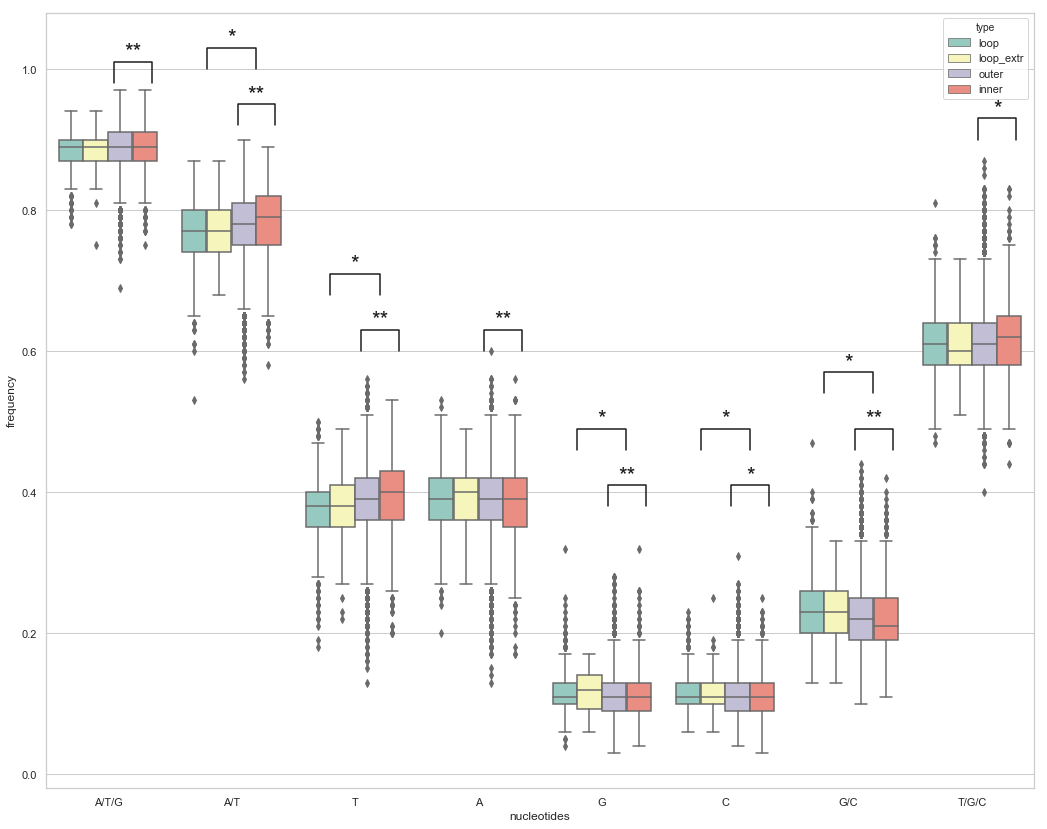

In [795]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=nuc_df2, palette="Set3")

# T
x1, x2 = 1.8, 2.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.63 + 0.05, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 2.05, 2.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.57 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# A
x1, x2 = 3.05, 3.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.57 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# G
x1, x2 = 3.8, 4.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.41 + 0.05, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 4.05, 4.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.35 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# A/T
x1, x2 = 0.8, 1.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.95 + 0.05, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 1.05, 1.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.89 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# G/C
x1, x2 = 5.8, 6.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.49 + 0.05, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 6.05, 6.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.43 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# A/T/G
x1, x2 = 0.05, 0.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.95 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# T/G/C
x1, x2 = 7.05, 7.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.87 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

# C
x1, x2 = 4.8, 5.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.41 + 0.05, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 5.05, 5.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.35 + 0.03, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)


plt.show()

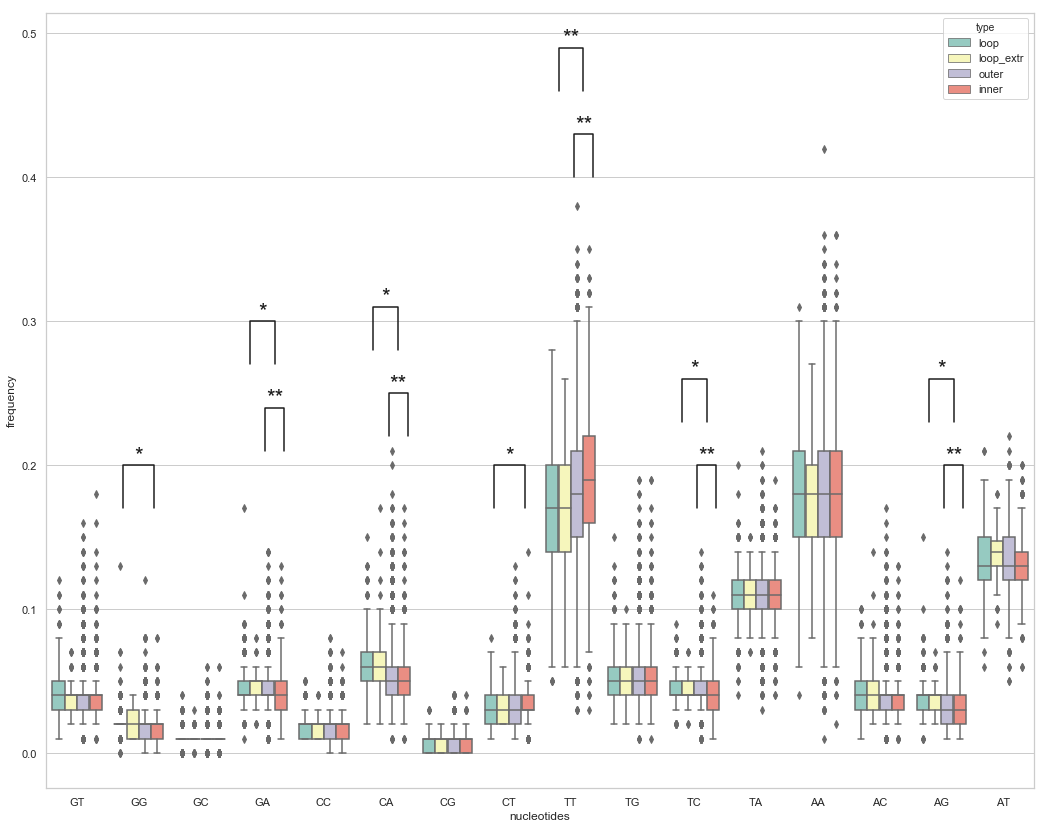

In [826]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=dinuc_df2, palette="Set3")

# GA
x1, x2 = 2.8, 3.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.25 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 3.05, 3.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.19 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# CA
x1, x2 = 4.8, 5.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.26 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 5.05, 5.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.2 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# TT
x1, x2 = 7.8, 8.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.44 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 8.05, 8.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.38 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# TC
x1, x2 = 9.8, 10.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.21 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 10.05, 10.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# AG
x1, x2 = 13.8, 14.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.21 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 14.05, 14.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)

# CG
#x1, x2 = 5.95, 5.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.07 + 0.02, 0.03, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

# GG
x1, x2 = 0.75, 1.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
# CT
x1, x2 = 6.75, 7.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

plt.show()

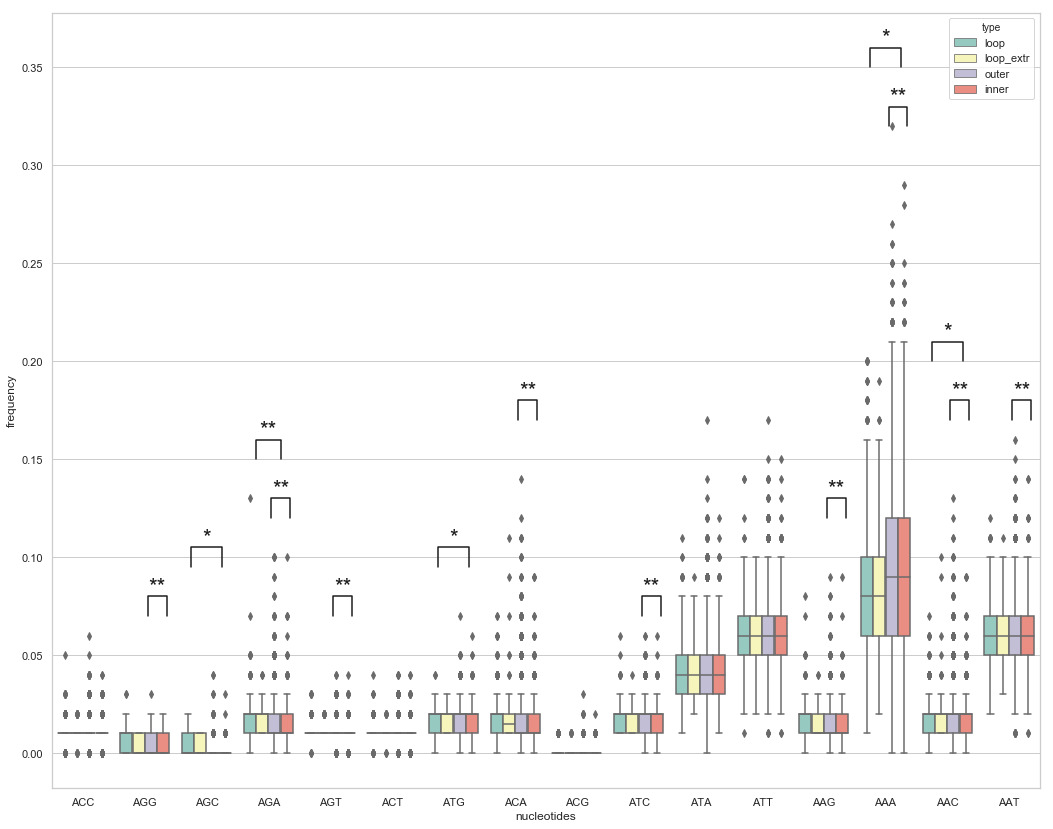

In [15]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df, palette="Set3")

# AGG
x1, x2 = 1.05, 1.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.05 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AGA
x1, x2 = 2.8, 3.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.13 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 3.05, 3.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.1 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AGT
x1, x2 = 4.05, 4.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.05 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# ACT
#x1, x2 = 4.95, 4.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.05 + 0.02, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
# ACA
x1, x2 = 7.05, 7.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# ACG
#x1, x2 = 7.95, 7.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.05 + 0.02, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
# ATC
x1, x2 = 9.05, 9.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.05 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AAG
#x1, x2 = 11.95, 11.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.1 + 0.02, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 12.05, 12.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.1 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AAA
x1, x2 = 12.75, 13.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.33 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 13.05, 13.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.3 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AAC
x1, x2 = 13.75, 14.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.18 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 14.05, 14.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# AAT
x1, x2 = 15.05, 15.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
#ATG
x1, x2 = 5.75, 6.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.075 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
#AGC
x1, x2 = 1.75, 2.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.075 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

plt.show()

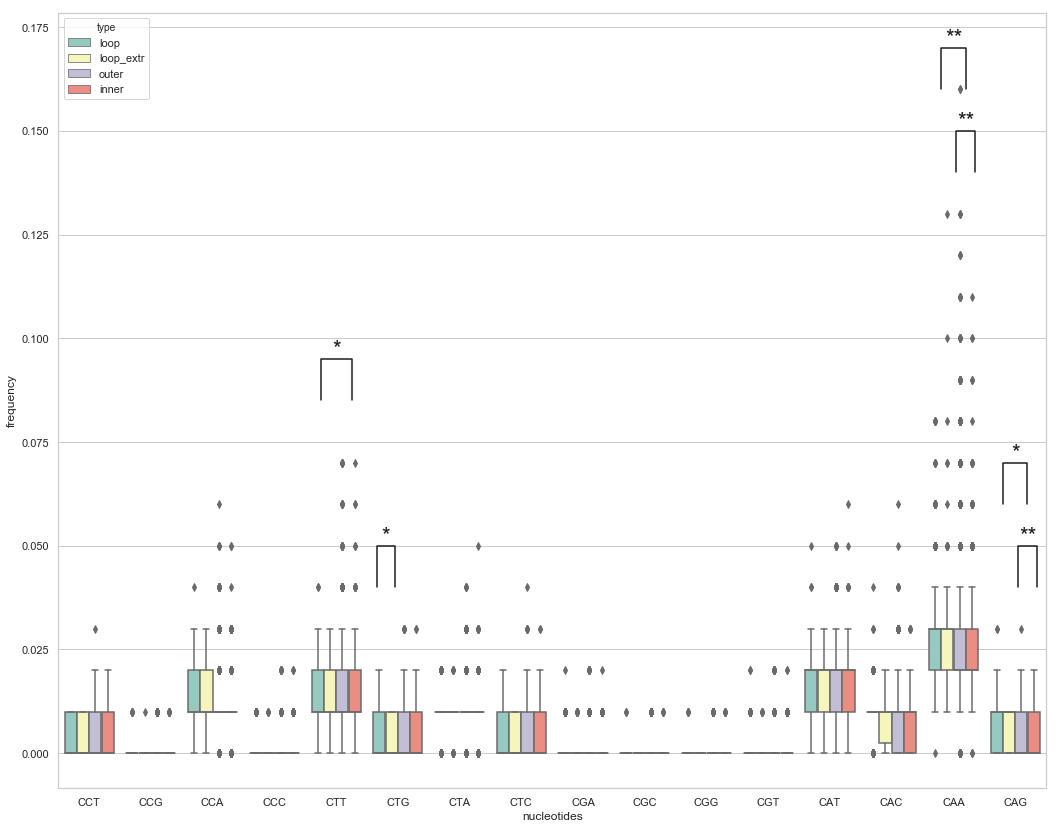

In [819]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df2, palette="Set3")
# CAA
x1, x2 = 13.8, 14.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.14 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 14.05, 14.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.12 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# CAG
x1, x2 = 14.8, 15.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.04 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 15.05, 15.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.02 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# CTG
x1, x2 = 4.95, 4.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.02 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
#CTT
x1, x2 = 3.75, 4.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.065 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

plt.show()

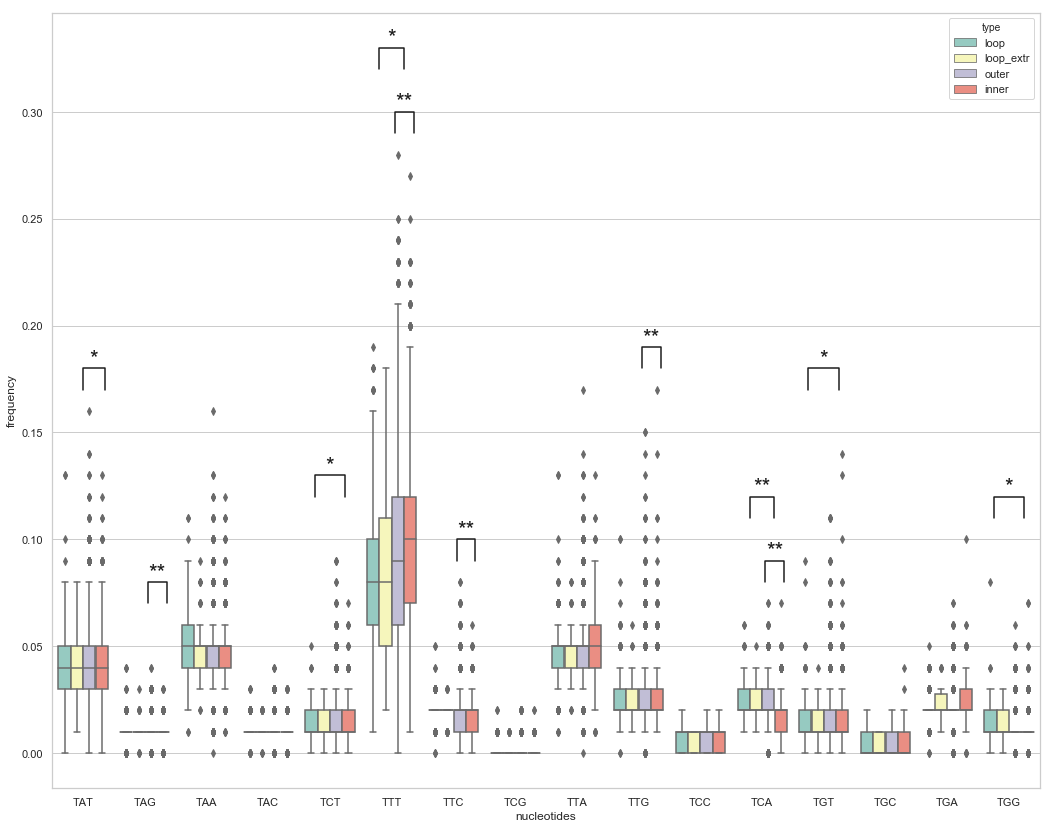

In [827]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df3, palette="Set3")
# TAT
x1, x2 = -0.0, 0.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
# TAG
#x1, x2 = 0.95, 0.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.05 + 0.02, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 1.05, 1.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.05 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# TTT
x1, x2 = 4.8, 5.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.3 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 5.05, 5.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.27 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
#TCT
x1, x2 = 3.75, 4.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.1 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
# TTC
x1, x2 = 6.05, 6.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.07 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# TTG
x1, x2 = 9.05, 9.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.16 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# TCA
x1, x2 = 10.8, 11.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.09 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 11.05, 11.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.06 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
#TGT
x1, x2 = 11.75, 12.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.15 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
#TGG
x1, x2 = 14.75, 15.25#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.09 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

plt.show()

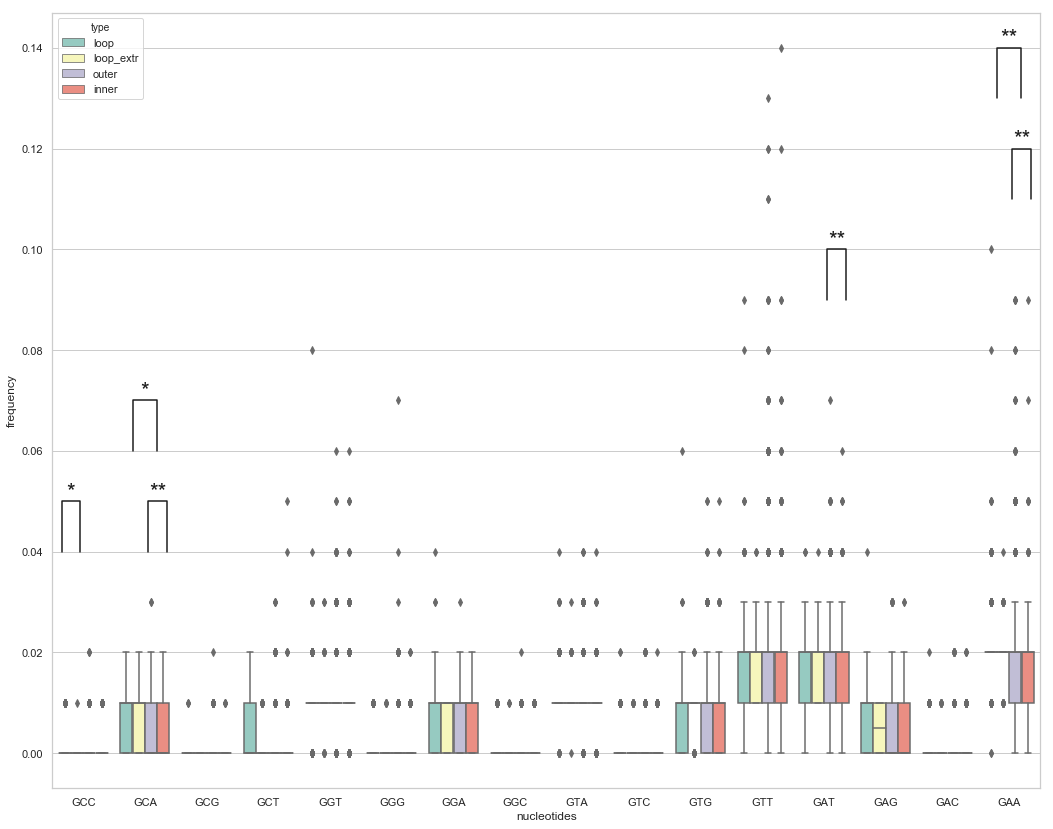

In [16]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df4, palette="Set3")
# GCA
x1, x2 = 0.8, 1.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.04 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
#x1, x2 = 0.95, 0.655#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = 0.02 + 0.02, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 1.05, 1.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.02 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# GAT
x1, x2 = 12.05, 12.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.07 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# GAA
x1, x2 = 14.8, 15.2#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.11 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
x1, x2 = 15.05, 15.355#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.09 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, fontsize=22)
# GCC
x1, x2 = -0.345, -0.05#.15, 7.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 0.02 + 0.02, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=22)

plt.show()

### P-values

In [411]:
nuc_df2 = pd.concat([nuc_df2, loops_extr_nuc_df2, temp_df, inner_temp_df])
dinuc_df2 = pd.concat([dinuc_df2, loops_extr_dinuc_df2, temp_df2, inner_temp_df2])
trinuc_df = pd.concat([trinuc_df, loops_extr_trinuc_df, temp_df3, inner_temp_df3])
trinuc_df2 = pd.concat([trinuc_df2, loops_extr_trinuc_df2, temp_df4, inner_temp_df4])
trinuc_df3 = pd.concat([trinuc_df3, loops_extr_trinuc_df3, temp_df5, inner_temp_df5])
trinuc_df4 = pd.concat([trinuc_df4, loops_extr_trinuc_df4, temp_df6, inner_temp_df6])

Inner vs outer

In [681]:
nucs_for_p = nuc_df2.nucleotides.unique().tolist() #['A', 'T']
dinucs_for_p = dinuc_df2.nucleotides.unique().tolist() #['TG', 'TA', 'AA', 'AC', 'AG', 'AT']
all_for_p = nucs_for_p + dinucs_for_p

In [683]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.01
for nuc in all_for_p:
    if (nuc in nucs_for_p):
        a = nuc_df2[nuc_df2['nucleotides'] == nuc]
    else:
        a = dinuc_df2[dinuc_df2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'outer']['frequency']
    a_loop = a[a['type'] == 'inner']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    #print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    # interpret
    if (p <= alpha) and (p > 0.001):
        #print('Same distribution (fail to reject H0)')
    #else:
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

C  Statistics=12398699.500, p=0.00273
Different distribution (reject H0)
T/G/C  Statistics=12342955.000, p=0.00101
Different distribution (reject H0)
GG  Statistics=12449685.000, p=0.00359
Different distribution (reject H0)
AT  Statistics=12370052.000, p=0.00148
Different distribution (reject H0)


In [744]:
trinuc_df_1 = pd.concat([trinuc_df, trinuc_df2])
trinuc_df_2 = pd.concat([trinuc_df3, trinuc_df4])

trinucs_for_p1 = trinuc_df_1.nucleotides.unique().tolist()
trinucs_for_p2 = trinuc_df_2.nucleotides.unique().tolist()
all_for_p = trinucs_for_p1 + trinucs_for_p2

In [747]:
p_values[p_values['nuc'] == 'TTT']

,nuc,p_value
37,TTT,2.111746e-10


In [746]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.001
for nuc in all_for_p:
    if (nuc in trinucs_for_p1):
        a = trinuc_df_1[trinuc_df_1['nucleotides'] == nuc]
    else:
        a = trinuc_df_2[trinuc_df_2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'outer']['frequency']
    a_loop = a[a['type'] == 'inner']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    if (p <= alpha): #and (p> 0.001):
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

AGG  Statistics=12133908.500, p=0.00000
Different distribution (reject H0)
AGA  Statistics=11845126.000, p=0.00000
Different distribution (reject H0)
AGT  Statistics=12455225.500, p=0.00008
Different distribution (reject H0)
ACA  Statistics=12327368.500, p=0.00021
Different distribution (reject H0)
ATC  Statistics=12064638.000, p=0.00000
Different distribution (reject H0)
AAG  Statistics=11848180.500, p=0.00000
Different distribution (reject H0)
AAA  Statistics=12185837.000, p=0.00003
Different distribution (reject H0)
AAC  Statistics=12044351.000, p=0.00000
Different distribution (reject H0)
AAT  Statistics=11913229.000, p=0.00000
Different distribution (reject H0)
CAA  Statistics=11617309.500, p=0.00000
Different distribution (reject H0)
CAG  Statistics=12375865.000, p=0.00042
Different distribution (reject H0)
TAT  Statistics=12110879.500, p=0.00000
Different distribution (reject H0)
TAG  Statistics=12208677.000, p=0.00000
Different distribution (reject H0)
TTT  Statistics=11798445.

In [466]:
forth_for_p2 = forth_df.nucleotides.unique().tolist()
fifth_for_p2 = fifth_df.nucleotides.unique().tolist()
all_for_p = forth_for_p2 + fifth_for_p2

In [487]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.001
for nuc in all_for_p:
    if (nuc in forth_for_p2):
        a = forth_df[forth_df['nucleotides'] == nuc]
    else:
        a = fifth_df[fifth_df['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'outer']['frequency']
    a_loop = a[a['type'] == 'inner']['frequency']
    if (len(a_dicty[a_dicty == 0.0]) == len(a_dicty)) and \
        (len(a_loop[a_loop == 0.0]) == len(a_loop)):
        continue
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    if p <= alpha:
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

AAAA  Statistics=11947634.500, p=0.00000
Different distribution (reject H0)
AAAG  Statistics=12184156.500, p=0.00000
Different distribution (reject H0)
GAAT  Statistics=12411081.500, p=0.00049
Different distribution (reject H0)
TTAG  Statistics=12188855.000, p=0.00000
Different distribution (reject H0)
TTAT  Statistics=12026814.500, p=0.00000
Different distribution (reject H0)
TTTT  Statistics=11741808.000, p=0.00000
Different distribution (reject H0)
TCAT  Statistics=12425558.000, p=0.00037
Different distribution (reject H0)
TCAA  Statistics=11801801.000, p=0.00000
Different distribution (reject H0)
TTCA  Statistics=12200179.000, p=0.00000
Different distribution (reject H0)
GACC  Statistics=12821035.500, p=0.00011
Different distribution (reject H0)
ACAA  Statistics=12098168.500, p=0.00000
Different distribution (reject H0)
ATTC  Statistics=12105492.500, p=0.00000
Different distribution (reject H0)
GTCT  Statistics=12815852.500, p=0.00077
Different distribution (reject H0)
ATAG  Statis

Loops vs loops with extrusion

In [684]:
nucs_for_p = nuc_df2.nucleotides.unique().tolist() 
dinucs_for_p = dinuc_df2.nucleotides.unique().tolist()
all_for_p = nucs_for_p + dinucs_for_p

In [687]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.1
for nuc in all_for_p:
    if (nuc in nucs_for_p):
        a = nuc_df2[nuc_df2['nucleotides'] == nuc]
    else:
        a = dinuc_df2[dinuc_df2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'loop']['frequency']
    a_loop = a[a['type'] == 'loop_extr']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    #print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    # interpret
    if p <= alpha:
        #print('Same distribution (fail to reject H0)')
    #else:
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

CG  Statistics=54023.000, p=0.05126
Different distribution (reject H0)


In [453]:
trinucs_for_p1 = trinuc_df.nucleotides.unique().tolist()
trinucs_for_p2 = trinuc_df2.nucleotides.unique().tolist()
all_for_p = trinucs_for_p1 + trinucs_for_p2

In [748]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.1
for nuc in all_for_p:
    if (nuc in trinucs_for_p1):
        a = trinuc_df_1[trinuc_df_1['nucleotides'] == nuc]
    else:
        a = trinuc_df_2[trinuc_df_2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'loop']['frequency']
    a_loop = a[a['type'] == 'loop_extr']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    if p <= alpha:
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

ACT  Statistics=55200.000, p=0.04137
Different distribution (reject H0)
ACG  Statistics=56265.000, p=0.03262
Different distribution (reject H0)
AAG  Statistics=54682.000, p=0.08591
Different distribution (reject H0)
CTG  Statistics=53823.000, p=0.04423
Different distribution (reject H0)
TAG  Statistics=55587.500, p=0.07122
Different distribution (reject H0)
GCC  Statistics=57570.000, p=0.09723
Different distribution (reject H0)
GCA  Statistics=54850.500, p=0.08833
Different distribution (reject H0)


### Бинарная классификация

In [383]:
!sh ./script.sh ../data/background/fasta/bin_loops_seq.fasta ../data/background/tsv/loops/bin_loops.tsv ../data/background/tsv/loops/bin_loops2.tsv
!sh ./script.sh ../data/background/fasta/bin_back_seq.fasta ../data/background/tsv/loops/bin_back.tsv ../data/background/tsv/loops/bin_back2.tsv

In [384]:
dicty_chars2 = pd.read_csv('../data/background/tsv/loops/bin_back2.tsv', sep='\t') 
loops_chars2 = pd.read_csv('../data/background/tsv/loops/bin_loops2.tsv', sep='\t')

In [828]:
nucs = ['A', 'C', 'T', 'G', 'G/C', 'A/T', 'A/T/G', 'T/G/C']
dinucs = ['AA', 'AC', 'AT', 'AG', 'CA', 'CC', 'CT', 'CG', 'TA', 'TC', 'TT', 'TG', 'GA', 'GC', 'GT', 'GG']
trinucs = []
for i in xrange(0, 4):
    for j in xrange(0, 4):
        for k in xrange(0, 4):
            trinucs.append(nucs[i] + nucs[j] + nucs[k])
half_len = len(trinucs)/2
trinucs2 = trinucs[half_len : ]
trinucs = trinucs[0 : half_len]

In [386]:
nuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(nucs)]
nuc_df2.loc[:,'type'] = 'loop'
dinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(dinucs)]
dinuc_df2.loc[:,'type'] = 'loop'
trinuc_df = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs)]
trinuc_df2 = loops_chars2.loc[loops_chars2['nucleotides'].isin(trinucs2)]
trinuc_df.loc[:,'type'] = 'loop'
trinuc_df2.loc[:,'type'] = 'loop'
nuc_df2.count()

nucleotides    9504
frequency      9504
bins           9504
Unnamed: 3        0
type           9504
dtype: int64

In [387]:
temp_df = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(nucs)]
temp_df.loc[:,'type'] = 'dicty'
temp_df2 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(dinucs)]
temp_df2.loc[:,'type'] = 'dicty'
temp_df3 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs)]
temp_df4 = dicty_chars2.loc[dicty_chars2['nucleotides'].isin(trinucs2)]
temp_df3.loc[:,'type'] = 'dicty'
temp_df4.loc[:,'type'] = 'dicty'
temp_df.count()

nucleotides    108064
frequency      108064
bins           108064
Unnamed: 3          0
type           108064
dtype: int64

In [554]:
np.unique(nuc_df2.type)

array(['inner', 'loop', 'loop_extr', 'outer'], dtype=object)

In [559]:
nuc_df2_cp = nuc_df2.copy()
dinuc_df2_cp = dinuc_df2.copy()
trinuc_df_cp = trinuc_df.copy()
trinuc_df2_cp = trinuc_df2.copy()
trinuc_df3_cp = trinuc_df3.copy()
trinuc_df4_cp = trinuc_df4.copy()

In [624]:
nuc_df2 = nuc_df2_cp.copy()
dinuc_df2 = dinuc_df2_cp.copy()
trinuc_df = trinuc_df_cp.copy()
trinuc_df2 = trinuc_df2_cp.copy()
trinuc_df3 = trinuc_df3_cp.copy()
trinuc_df4 = trinuc_df4_cp.copy()

In [625]:
nuc_df2.shape, nuc_df2_cp.shape

((121208, 5), (121208, 5))

In [628]:
np.unique(nuc_df2.type)

array(['dicty', 'loop'], dtype=object)

In [829]:
tmp_nuc = nuc_df2[nuc_df2['type'] == 'loop_extr'][['nucleotides', 'frequency', 'bins']]
tmp_nuc['type'] = 'loop'
tmp_nuc2 = nuc_df2[nuc_df2['type'] == 'inner'][['nucleotides', 'frequency', 'bins']]
tmp_nuc2['type'] = 'dicty'
tmp_nuc3 = nuc_df2[nuc_df2['type'] == 'outer'][['nucleotides', 'frequency', 'bins']]
tmp_nuc3['type'] = 'dicty'
bin_nuc_df2 = pd.concat([tmp_nuc.copy(), tmp_nuc2.copy(), tmp_nuc3.copy()])

tmp_nuc = dinuc_df2[dinuc_df2['type'] == 'loop_extr'][['nucleotides', 'frequency', 'bins']]
tmp_nuc['type'] = 'loop'
tmp_nuc2 = dinuc_df2[dinuc_df2['type'] == 'inner'][['nucleotides', 'frequency', 'bins']]
tmp_nuc2['type'] = 'dicty'
tmp_nuc3 = dinuc_df2[dinuc_df2['type'] == 'outer'][['nucleotides', 'frequency', 'bins']]
tmp_nuc3['type'] = 'dicty'
bin_dinuc_df2 = pd.concat([tmp_nuc.copy(), tmp_nuc2.copy(), tmp_nuc3.copy()])

tmp_nuc = trinuc_df_1[trinuc_df_1['type'] == 'loop_extr'][['nucleotides', 'frequency', 'bins']]
tmp_nuc['type'] = 'loop'
tmp_nuc2 = trinuc_df_1[trinuc_df_1['type'] == 'inner'][['nucleotides', 'frequency', 'bins']]
tmp_nuc2['type'] = 'dicty'
tmp_nuc3 = trinuc_df_1[trinuc_df_1['type'] == 'outer'][['nucleotides', 'frequency', 'bins']]
tmp_nuc3['type'] = 'dicty'
bin_trinuc_df = pd.concat([tmp_nuc.copy(), tmp_nuc2.copy(), tmp_nuc3.copy()])

tmp_nuc = trinuc_df_2[trinuc_df_2['type'] == 'loop_extr'][['nucleotides', 'frequency', 'bins']]
tmp_nuc['type'] = 'loop'
tmp_nuc2 = trinuc_df_2[trinuc_df_2['type'] == 'inner'][['nucleotides', 'frequency', 'bins']]
tmp_nuc2['type'] = 'dicty'
tmp_nuc3 = trinuc_df_2[trinuc_df_2['type'] == 'outer'][['nucleotides', 'frequency', 'bins']]
tmp_nuc3['type'] = 'dicty'
bin_trinuc_df2 = pd.concat([tmp_nuc.copy(), tmp_nuc2.copy(), tmp_nuc3.copy()])

In [ ]:
nuc_df2 = pd.concat([nuc_df2, temp_df])
dinuc_df2 = pd.concat([dinuc_df2, temp_df2])
trinuc_df = pd.concat([trinuc_df, temp_df3])
trinuc_df2 = pd.concat([trinuc_df2, temp_df4])

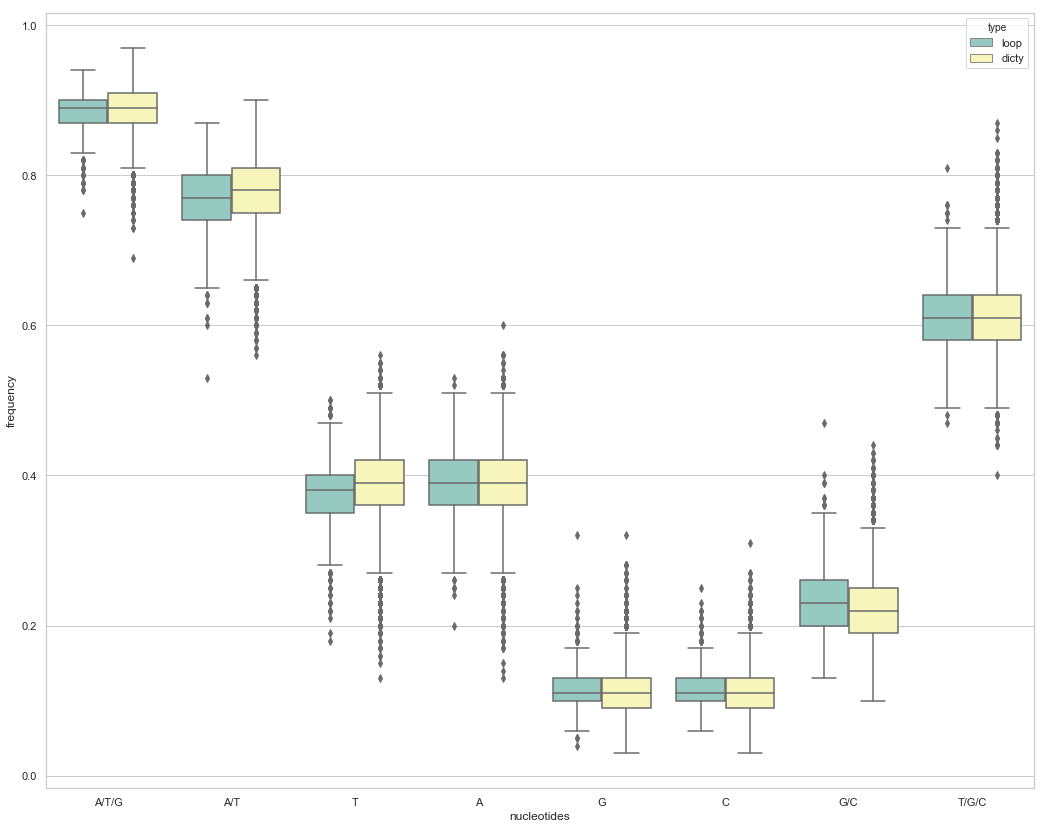

In [389]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=nuc_df2, palette="Set3")
plt.show()

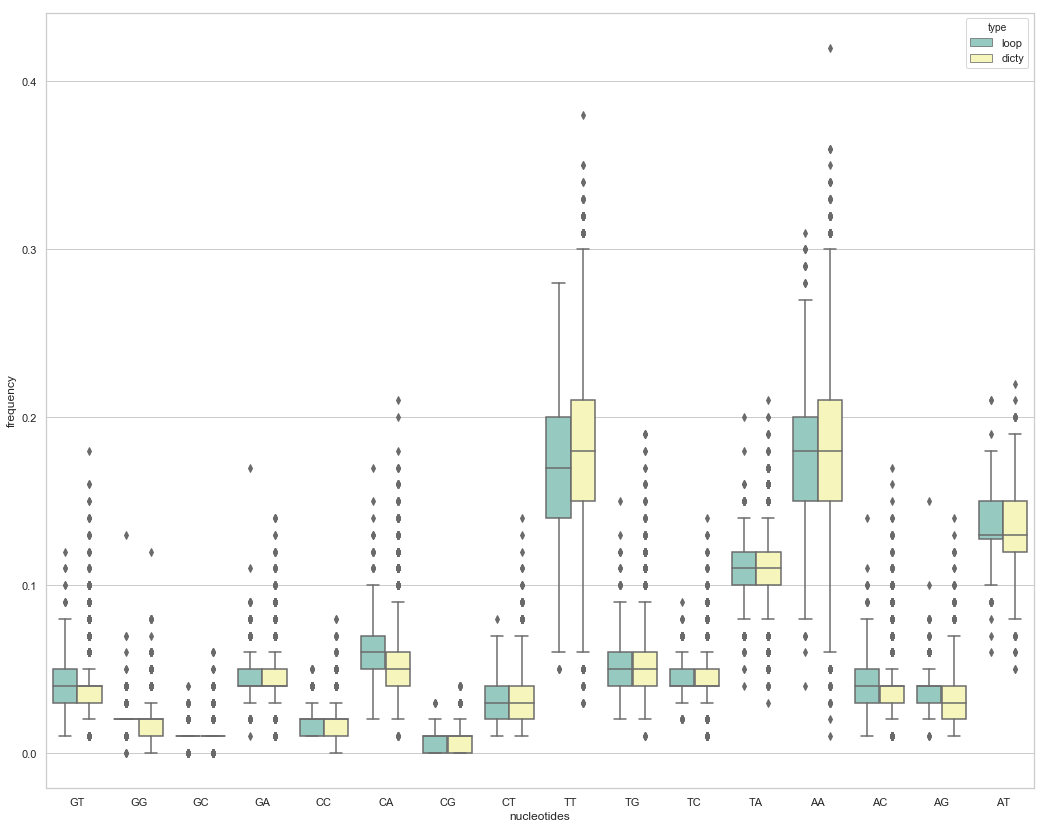

In [390]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=dinuc_df2, palette="Set3")
plt.show()

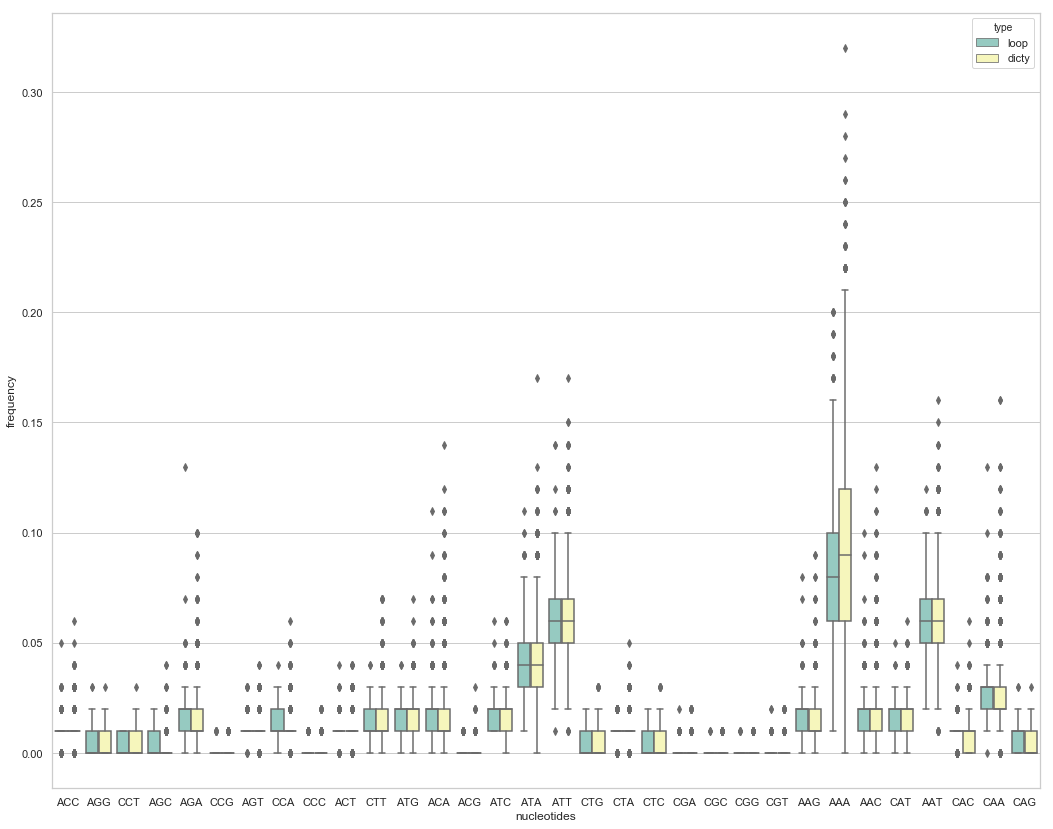

In [391]:
sns.set(style="whitegrid", rc = {'figure.figsize':(17.7,14.27)})
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df, palette="Set3")
plt.show()

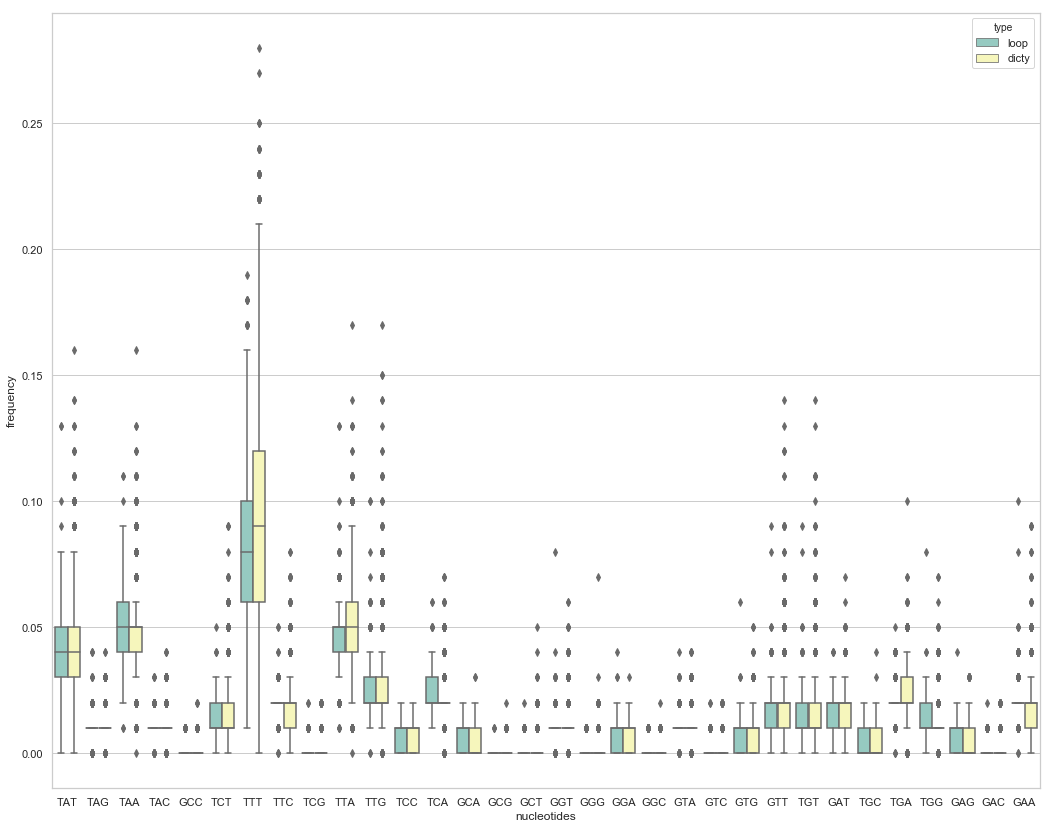

In [392]:
ax = sns.boxplot(x="nucleotides", y="frequency", hue="type", data=trinuc_df2, palette="Set3")
plt.show()

# P-value 

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [830]:
nucs_for_p = bin_nuc_df2.nucleotides.unique().tolist() #['A', 'T']
dinucs_for_p = bin_dinuc_df2.nucleotides.unique().tolist() #['TG', 'TA', 'AA', 'AC', 'AG', 'AT']
all_for_p = nucs_for_p + dinucs_for_p

In [832]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.01
#alpha = 0.1
for nuc in all_for_p:
    if (nuc in nucs_for_p):
        a = bin_nuc_df2[bin_nuc_df2['nucleotides'] == nuc]
    else:
        a = bin_dinuc_df2[bin_dinuc_df2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'dicty']['frequency']
    a_loop = a[a['type'] == 'loop']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    #print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    # interpret
    if (p <= alpha) and (p > 0.00):
    #if (p <= alpha):
        #print('Same distribution (fail to reject H0)')
    #else:
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

A/T  Statistics=661082.500, p=0.00573
Different distribution (reject H0)
T  Statistics=640633.000, p=0.00130
Different distribution (reject H0)
G/C  Statistics=663925.000, p=0.00693
Different distribution (reject H0)
GA  Statistics=668106.500, p=0.00732
Different distribution (reject H0)
CA  Statistics=601563.000, p=0.00003
Different distribution (reject H0)
TT  Statistics=643399.000, p=0.00161
Different distribution (reject H0)
AG  Statistics=615938.000, p=0.00010
Different distribution (reject H0)


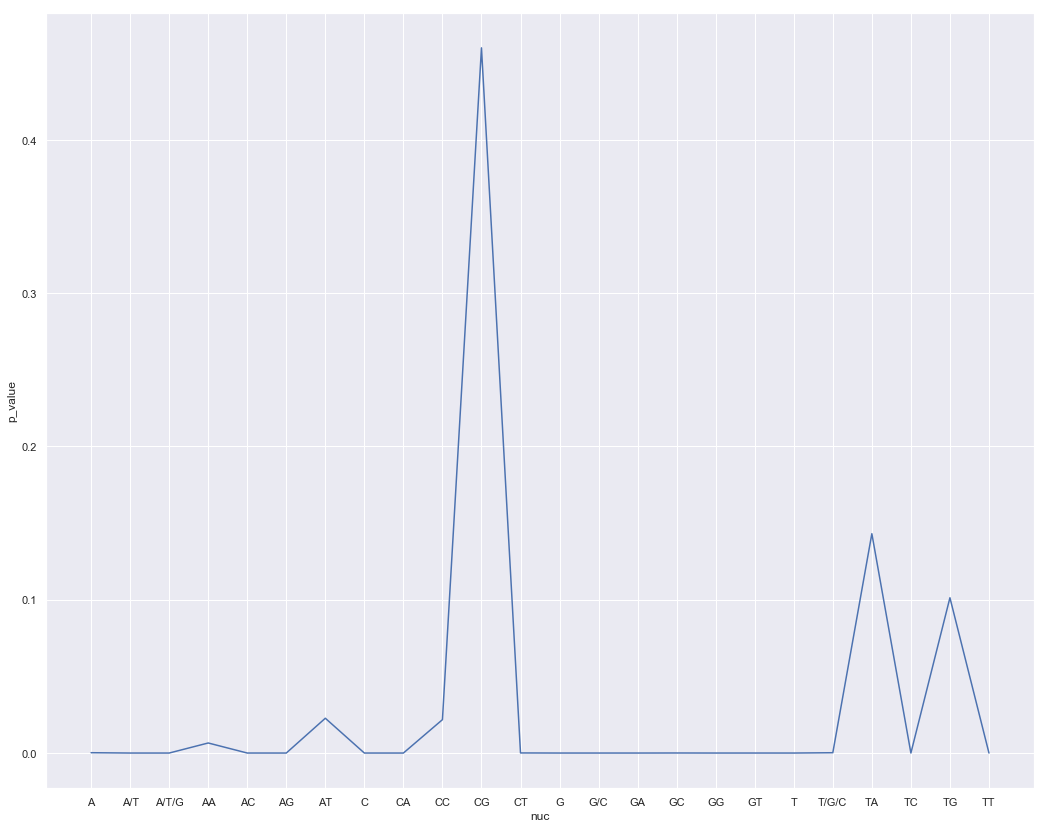

In [125]:
sns.set()
ax = sns.lineplot(x = 'nuc', y = 'p_value', data=p_values)
plt.show()

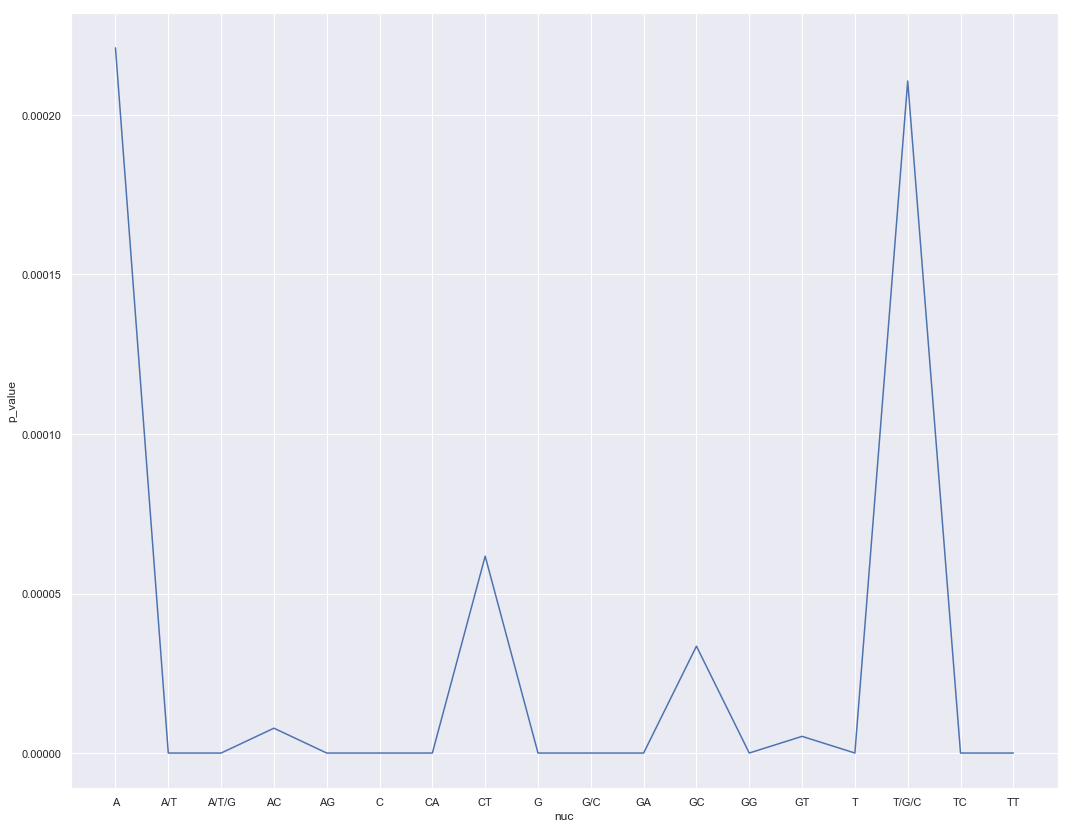

In [126]:
sns.set()
ax = sns.lineplot(x = 'nuc', y = 'p_value', data=imp_p_values)
plt.show()

In [833]:
trinucs_for_p1 = bin_trinuc_df.nucleotides.unique().tolist()
trinucs_for_p2 = bin_trinuc_df2.nucleotides.unique().tolist()
all_for_p = trinucs_for_p1 + trinucs_for_p2

In [834]:
p_values = pd.DataFrame(columns=['nuc', 'p_value'])
imp_p_values = pd.DataFrame(columns=['nuc', 'p_value'])
alpha = 0.01
for nuc in all_for_p:
    if (nuc in trinucs_for_p1):
        a = bin_trinuc_df[bin_trinuc_df['nucleotides'] == nuc]
    else:
        a = bin_trinuc_df2[bin_trinuc_df2['nucleotides'] == nuc]
    a_dicty = a[a['type'] == 'dicty']['frequency']
    a_loop = a[a['type'] == 'loop']['frequency']
    stat, p = st.mannwhitneyu(a_loop, a_dicty)
    p_values = p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
    if (p <= alpha) and (p > 0.001):
        imp_p_values = imp_p_values.append({'nuc': nuc, 'p_value': p}, ignore_index=True)
        print('%s  Statistics=%.3f, p=%.5f' % (nuc, stat, p))
        print('Different distribution (reject H0)')

AGC  Statistics=687816.000, p=0.00482
Different distribution (reject H0)
ATG  Statistics=675101.500, p=0.00675
Different distribution (reject H0)
AAA  Statistics=649200.000, p=0.00247
Different distribution (reject H0)
AAC  Statistics=677573.000, p=0.00933
Different distribution (reject H0)
CTT  Statistics=682388.000, p=0.00912
Different distribution (reject H0)
CAG  Statistics=666941.000, p=0.00295
Different distribution (reject H0)
TCT  Statistics=673827.500, p=0.00546
Different distribution (reject H0)
TTT  Statistics=650990.000, p=0.00282
Different distribution (reject H0)
TGT  Statistics=676084.500, p=0.00819
Different distribution (reject H0)
TGG  Statistics=684851.000, p=0.00548
Different distribution (reject H0)
GCA  Statistics=659397.500, p=0.00148
Different distribution (reject H0)


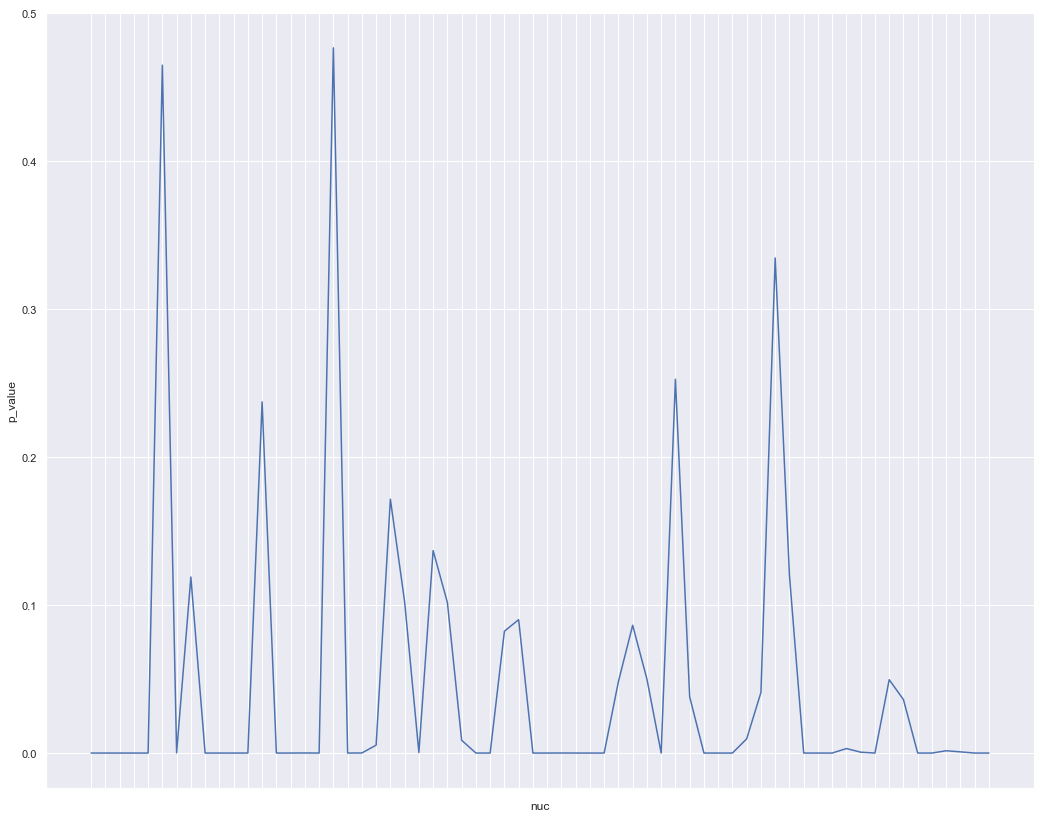

In [129]:
sns.set()
ax = sns.lineplot(x = 'nuc', y = 'p_value', data=p_values)
ax.set_xticklabels(labels = plt.xticks()[1], rotation=90)
plt.show()

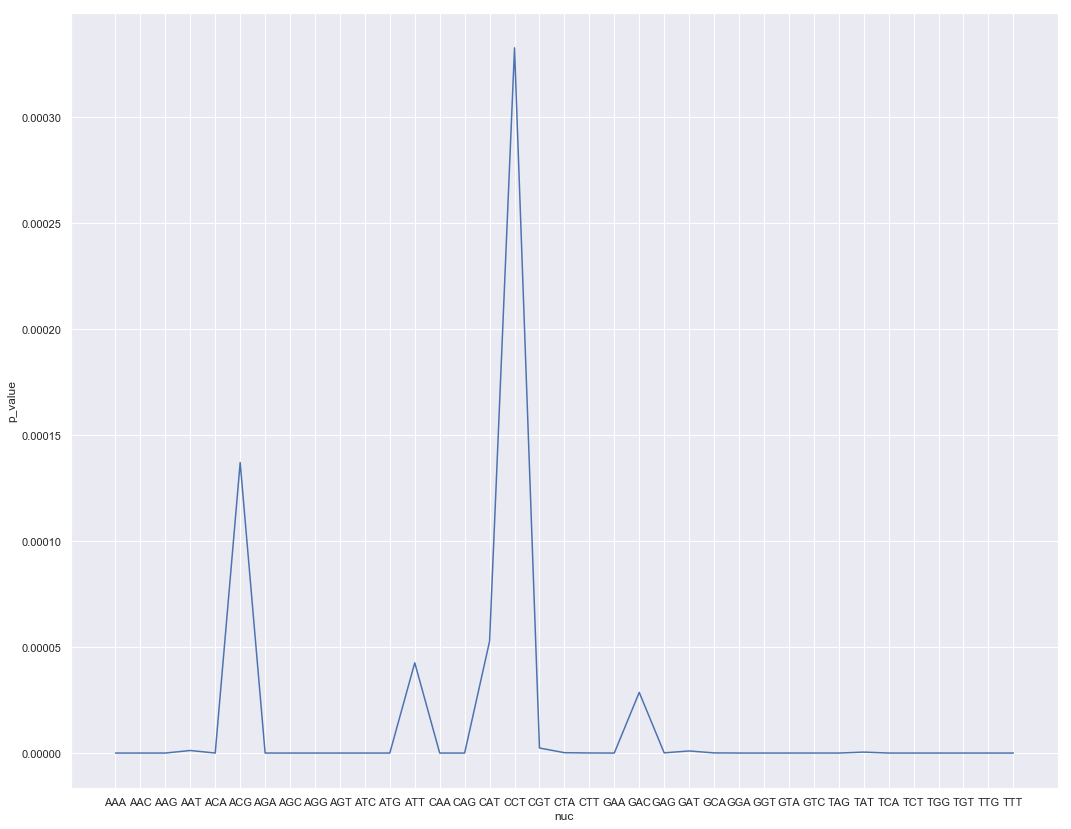

In [130]:
sns.set()
ax = sns.lineplot(x = 'nuc', y = 'p_value', data=imp_p_values)
plt.show()